In [ ]:
# #only run once
# #!pip install nes-py==0.2.6
# !brew update
# !brew install ffmpeg
# !brew install libsm
# !brew install libxext
# !brew install mesa
# !pip install opencv-python
# !pip install gym-super-mario-bros
# !pip install gym

In [1]:
import torch
import torch.nn as nn
import random
import gym
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros import SuperMarioBrosEnv
from tqdm import tqdm
import pickle 
import gym
import numpy as np
import collections 
import cv2
import matplotlib.pyplot as plt
import time
import datetime
import json

In [2]:
from toolkit.gym_env import *
from toolkit.action_utils import *
from toolkit.marlios_model import *
from toolkit.constants import *

CONSECUTIVE_ACTIONS = 2

%load_ext autoreload
%autoreload 2

In [24]:
def show_state(env, ep=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Episode: %d %s" % (ep, info))
    plt.axis('off')

    # display.clear_output(wait=True)
    # display.display(plt.gcf())
    display(plt.gcf(), clear=True)

def make_env(env, actions=ACTION_SPACE):
    env = MaxAndSkipEnv(env, skip=4) # I am testing out fewer fram repetitions for our two actions modelling
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    env = ScaledFloatFrame(env)
    return JoypadSpace(env, actions)

def generate_epoch_time_id():
    epoch_time = int(time.time())
    return str(epoch_time)

def save_checkpoint(agent, total_rewards, terminal_info, run_id):
    with open(f"ending_position-{run_id}.pkl", "wb") as f:
        pickle.dump(agent.ending_position, f)
    with open(f"num_in_queue-{run_id}.pkl", "wb") as f:
        pickle.dump(agent.num_in_queue, f)
    with open(f"total_rewards-{run_id}.pkl", "wb") as f:
        pickle.dump(total_rewards, f)
    with open(f"terminal_info-{run_id}.pkl", "wb") as f:
        pickle.dump(terminal_info, f)
    if agent.double_dq:
        torch.save(agent.local_net.state_dict(), f"dq1-{run_id}.pt")
        torch.save(agent.target_net.state_dict(), f"dq2-{run_id}.pt")
    else:
        torch.save(agent.dqn.state_dict(), f"dq-{run_id}.pt")  

def load_rewards(from_file):
     with open(from_file, 'rb') as f:
        total_rewards = pickle.load(f)
        return total_rewards

def plot_rewards(ep_per_stat = 100, total_rewards = [], from_file = None):
    if from_file != None:
        total_rewards = load_rewards(total_rewards)
       
    avg_rewards = [np.mean(total_rewards[i:i+ep_per_stat]) for i in range(0, len(total_rewards), ep_per_stat)]
    std_rewards = [np.std(total_rewards[i:i+ep_per_stat]) for i in range(0, len(total_rewards), ep_per_stat)]

    fig, ax = plt.subplots()
    ax.plot(avg_rewards, label='Average Rewards')
    ax.fill_between(range(len(avg_rewards)), np.subtract(avg_rewards, std_rewards), np.add(avg_rewards, std_rewards), alpha=0.2, label='Reward StdDev')

    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    xtick_labels = [str(i*ep_per_stat) for i in range(len(avg_rewards))]
    plt.xticks(range(len(avg_rewards)), xtick_labels)
    ax.legend(loc='lower right')
    plt.show()

# define the run function with some helpful debugging stats

def run(training_mode=True, pretrained=False, lr=0.0001, gamma=0.90, exploration_decay=0.995, exploration_min=0.02, 
        ep_per_stat = 100, exploration_max = 1,
        mario_env='SuperMarioBros-1-1-v0', action_space=TWO_ACTIONS_SET, num_episodes=1000, run_id=None, n_actions=5):
   
    run_id = run_id or generate_epoch_time_id()
    fh = open(f'progress-{run_id}.txt', 'a')
    env = gym.make(mario_env)
    env = make_env(env, ACTION_SPACE)


    # observation_space = env.observation_space.shape # not using this anymore

    #todo: add agent params as a setting/create different agents in diff functions to run 
    exploration_max = min(1, max(exploration_max, exploration_min))

    agent = DQNAgent(
                     action_space=action_space,
                     max_memory_size=30000,
                     batch_size=64,
                     gamma=gamma,
                     lr=lr,
                     dropout=None,
                     exploration_max=exploration_max,
                     exploration_min=exploration_min,
                     exploration_decay=exploration_decay,
                     double_dq=True,
                     pretrained=pretrained,
                     run_id=run_id,
                     n_actions=n_actions)
    
    
    # num_episodes = 10
    env.reset()
    total_rewards = []
    total_info = []

    if pretrained:
        total_rewards = load_rewards(from_file='total_rewards-{}.pkl'.format(run_id))
    
    offset = len(total_rewards)   
    for iteration in tqdm(range(num_episodes)):
        ep_num = offset + iteration

        state = env.reset()[-1] # take the final dimension of shape (4, 84, 84) leaving shape (84, 84) 
        state = torch.Tensor([state]).unsqueeze(0) # converts (1, 84, 84) to (1, 1, 84, 84)
        total_reward = 0
        steps = 0

        action_freq = {}
        while True:
            if not training_mode:
                show_state(env, ep_num)


            two_actions_index = agent.act(state)
            two_actions_vector = agent.cur_action_space[0, two_actions_index[0]]
            two_actions = vec_to_action(two_actions_vector.cpu()) # tuple of actions

            # debugging info
            key = " | ".join([",".join(i) for i in two_actions])
            if key in action_freq:
                action_freq[key] += 1
            else:
                action_freq[key] = 1
            
            steps += 1
            reward = 0
            info = None
            terminal = False
            for action in two_actions: 
                if not terminal:
                    # compute index into ACTION_SPACE of our action
                    step_action = ACTION_TO_INDEX[action]

                    state_next, cur_reward, terminal, info = env.step(step_action)
                    total_reward += cur_reward
                    reward += cur_reward
                    
            state_next = torch.Tensor([state_next[-1]]).unsqueeze(0)
            reward = torch.tensor([reward]).unsqueeze(0)        
            terminal = torch.tensor([int(terminal)]).unsqueeze(0)
            
            if training_mode:
                agent.remember(state, two_actions_index, reward, state_next, terminal)
                agent.experience_replay()
            
            state = state_next
            if terminal:
                break

        total_info.append(info)
        total_rewards.append(total_reward)

        if training_mode and (ep_num % ep_per_stat) == 0 and ep_num != 0:
            save_checkpoint(agent, total_rewards, total_info, run_id)

        with open(f'total_reward-{run_id}.txt', 'a') as f:
            f.write("Total reward after episode {} is {}\n".format(ep_num + 1, total_rewards[-1]))
            if (ep_num%100 == 0):
                f.write("==================\n")
                f.write("{} current time at episode {}\n".format(datetime.datetime.now(), ep_num+1))
                f.write("==================\n")
            #print("Total reward after episode {} is {}".format(ep_num + 1, total_rewards[-1]))
            num_episodes += 1
        
        with open(f'actions_chosen-{run_id}.txt', 'a') as f:
            f.write("Action Frequencies for Episode {}, Exploration = {:4f}\n".format(ep_num + 1, agent.exploration_rate))
            f.write(json.dumps(action_freq) + "\n\n")
    
    if training_mode:
        save_checkpoint(agent, total_rewards, total_info, run_id)
    
    env.close()
    fh.close()
    
    if num_episodes > ep_per_stat:
        plot_rewards(ep_per_stat=ep_per_stat, total_rewards=total_rewards)


In [18]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
# rerun with pretrained model:
run_id = 1681856162
run(training_mode=True, 
    pretrained=True, # use the pretrained model
    ep_per_stat=100, 
    num_episodes=1000,
    run_id=run_id,
    lr=0.00001,
    exploration_min=0.02,
    exploration_max =0.02, # setting this to the min for the rerun model
    exploration_decay=0.9995, 
    action_space=SIMPLE_MOVEMENT,
    n_actions=len(SIMPLE_MOVEMENT)+2)

  2%|▏         | 20/1000 [01:20<15:46,  1.04it/s]  

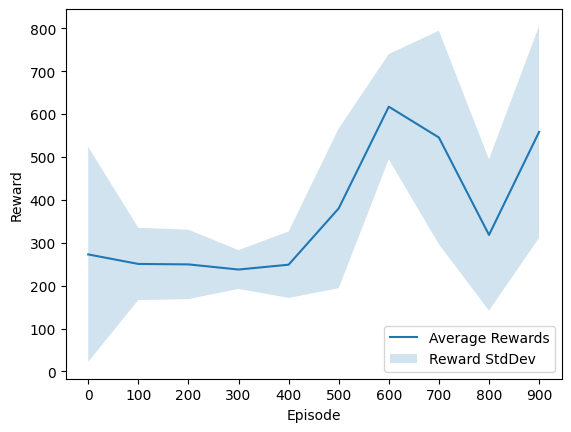

In [23]:
file_name = "total_rewards-{}.pkl".format('1681856162')
total_rewards = load_rewards(file_name)

plot_rewards(ep_per_stat=100, total_rewards=total_rewards)

# ep_per_stat = 100  # number of episodes to average over

# Debugging